In [2]:
# ===================================
# !!! SET UP PATH AND MERGE FILES !!!
# ===================================

import csv
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord

trials = 10000
path = '/home/ambra/Desktop/cluster-morgana/run0406_%dx/run0406/run0406_ID000126/csv/' %trials

Nchunk = 20

texp = [1,5,10,100]
sigma = [5]
chunk = [i+1 for i in range(Nchunk)]

#csvName[texp][chunk]
csvName = [[]*i for i in range(len(texp))]
for i in range(len(chunk)) :  
    for j in range(len(texp)) :
        csvName[j].append('run0406_v07_%ds_chunk%02d.csv' % (texp[j], chunk[i]))
#        print(csvName[j][i])
        
# merge files ---!
csvMerged= []
for j in range(len(texp)) :
    csvMerged.append('run0406_%dx_%ds.csv' % (trials,texp[j]))

    fout = open(path+csvMerged[j],'w+')
    # first file ---!
    for line in open(path+csvName[j][0]):
        fout.write(line)
    # remaining files ---!    
    for i in range(len(chunk)-1):
        f = open(path+csvName[j][i+1])
        next(f) # skip the header ---!
        for line in f:
             fout.write(line)
        f.close() 
    fout.close()
    
print(csvMerged)

# covariance for CI RA&DEC ---!
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

# data params ---!
threshold = 0.5
texp=[1,5,10,100]
# initialize SphDistance calc ---!
trueRA = 33.057
trueDEC = -51.841
true_coord = SkyCoord(ra = trueRA*u.deg, dec = trueDEC*u.deg, frame='fk5')
# conf intervals params ---!
nstd = [1,2,3,5]
conf_prob = [0.6827, 0.9545, 0.9973, 0.99994]
# img params ---!
fontsize=12
CI_colors = ['k', 'r', 'g', 'w']


['run0406_10000x_1s.csv', 'run0406_10000x_5s.csv', 'run0406_10000x_10s.csv', 'run0406_10000x_100s.csv']


verify trials =  17000
verify trials =  10000


================ texp = 1s ==============


ZERO DETECTION RATE : 19.92
DETECTION RATE : 80.08
DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 71.43
FIT RATIO WITHIN 0.5deg FROM TRUE POSITION: 71.38
check fit values std texp=1 : 0.025284780294499678


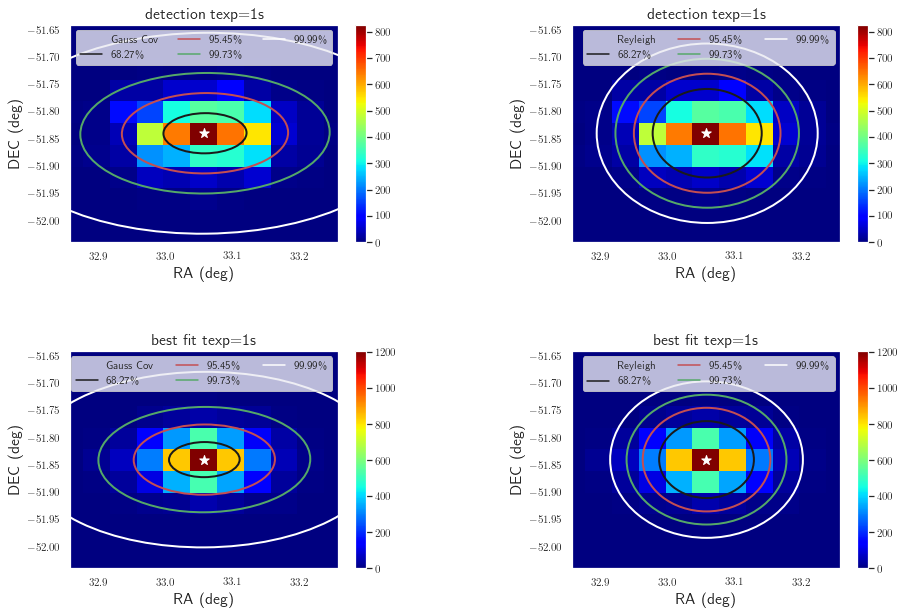



================ texp = 5s ==============


ZERO DETECTION RATE : 0.030000000000001137
DETECTION RATE : 99.97
DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 99.97
FIT RATIO WITHIN 0.5deg FROM TRUE POSITION: 99.97
check fit values std texp=5 : 0.009520449252829393


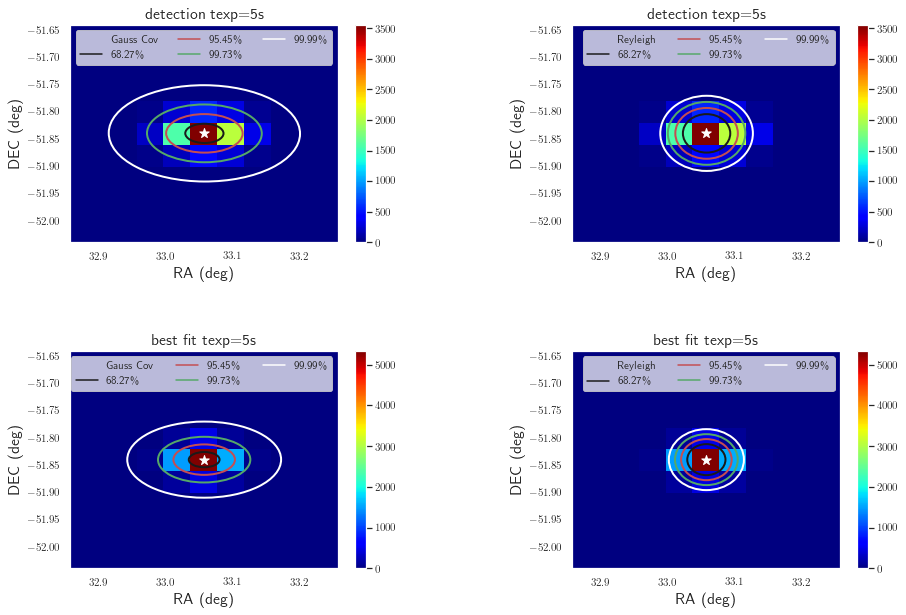



================ texp = 10s ==============


ZERO DETECTION RATE : 0.0
DETECTION RATE : 100.0
DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0
FIT RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0
check fit values std texp=10 : 0.007184322616142799


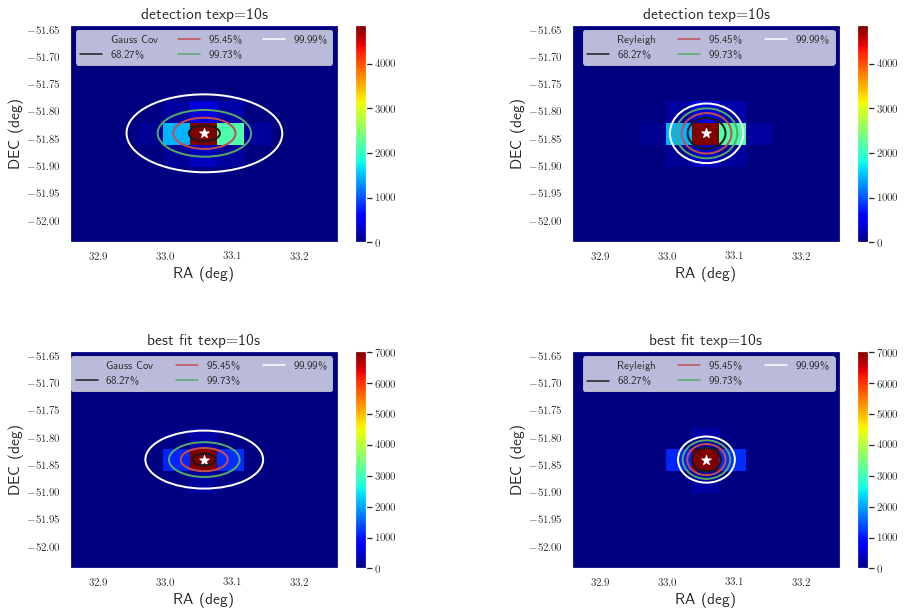



================ texp = 100s ==============


ZERO DETECTION RATE : 0.0
DETECTION RATE : 100.0
DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0
FIT RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0
check fit values std texp=100 : 0.0031298572293283417


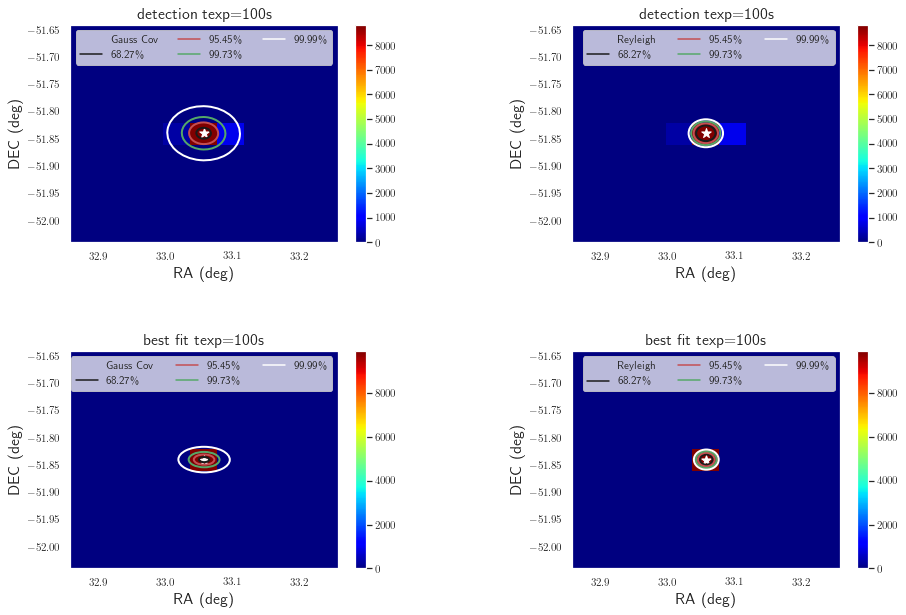

In [5]:
# ======================================
# !!! CONFIDENCE INTERVAL HISTOGRAMS !!!
# ======================================

import matplotlib.pyplot as plt
import seaborn as sns
from astropy import units as u
from astropy.coordinates import SkyCoord
from matplotlib.patches import Rectangle
from scipy.stats import rayleigh, norm
from matplotlib.lines import Line2D

from scipy import stats
from matplotlib.patches import Ellipse, Circle
from mpl_toolkits.axes_grid1 import make_axes_locatable


# hist params ---!
#width_det = 0.02
#nbin_det = int(threshold / width_det)
#width_fit = 0.01
#nbin_fit = int(threshold / width_fit)
width = 0.02
nbin = int(threshold / width)

for n in range(len(texp)) :  
        
    # store values ---!
    filename = csvMerged[n]
    
    # load DataFrame and column names ---!
    df = pd.read_csv(path+filename)
    cols = list(df.columns)
    trials = len(df[cols[0]])
    print('verify trials = ', trials)  if n == 0 else None
    # drop duplicates ---! 
    df.sort_values(cols[0], inplace = True) 
    # dropping ALL duplicte values 
    df.drop_duplicates(subset=cols[0], keep='last', inplace=True) 
    trials = len(df[cols[0]])
    print('verify trials = ', trials)  if n == 0 else None
    # drop NaN ---!
    df = df.dropna()
        
    print('\n\n================ texp = %ds ==============\n\n' %texp[n])
    
    # set arrays ---!
    trial = np.array(df[cols[0]])
    raDet = np.array(df[cols[5]])
    decDet = np.array(df[cols[6]])
    raFit = np.array(df[cols[7]])
    decFit = np.array(df[cols[8]])
    
    perc = 100 * (len(trial)/trials)
    print('ZERO DETECTION RATE :', 100-perc)
    print('DETECTION RATE :', perc)
    
    # DETECTION ---!
    distance_det = []
    d_det = []
    ra_det = []
    dec_det = []

    for i in range(len(raDet)) :
        if -90 <= decDet[i] <= 90 and 0 <= raDet[i] <= 360 :
            det_coord = SkyCoord(ra = raDet[i]*u.deg, dec = decDet[i]*u.deg, frame='fk5')
            dist = float(true_coord.separation(det_coord).deg)
            distance_det.append(dist)                  
    
            if dist < threshold :
                d_det.append(dist)
                ra_det.append(raDet[i]) 
                dec_det.append(decDet[i]) 
            
    perc_det = len(d_det)/trials * 100
    perc_det2 = len(d_det)/len(distance_det) * 100
    print('DET RATIO WITHIN %.1fdeg FROM TRUE POSITION:' %threshold, perc_det)
    
    # MEAN DET ---!
    mean_raDet_near = np.nanmean(ra_det)
    mean_decDet_near = np.nanmean(dec_det)
    mean_det_near = np.nanmean(d_det)
    std_d_det_near = np.nanstd(d_det)
    
    tmp = 0
    for i in range(len(d_det)) :
        tmp += d_det[i]**2
        
    MLE_det = np.sqrt(1/(2*len(d_det)) * tmp)   
    
    # FIT MAX LIKELIHOOD ---!
    distance_fit = []
    d_fit = []
    ra_fit = []
    dec_fit = []

    for i in range(len(raFit)) :
        if -90 <= decFit[i] <= 90 and 0 <= raFit[i] <= 360 :
            fit_coord = SkyCoord(ra = raFit[i]*u.deg, dec = decFit[i]*u.deg, frame='fk5')
            dist = float(true_coord.separation(fit_coord).deg)
            distance_fit.append(dist)                  
    
            if dist < threshold :
                d_fit.append(dist)
                ra_fit.append(raFit[i]) 
                dec_fit.append(decFit[i]) 
        
    perc_fit = len(d_fit)/trials * 100
#    perc_fit2 = len(d_fit)/len(distance_fit) * 100
    print('FIT RATIO WITHIN %.1fdeg FROM TRUE POSITION:' %threshold, perc_fit)  

    # MEAN FIT ---!
    mean_raFit_near = np.nanmean(ra_fit)
    mean_decFit_near = np.nanmean(dec_fit)
    mean_fit_near = np.nanmean(d_fit)
    std_d_fit_near = np.nanstd(d_fit)
    
    print('check fit values std texp=%d :' %texp[n], std_d_fit_near)
    
    tmp = 0
    for i in range(len(d_fit)) :
        tmp += d_fit[i]**2
        
    MLE_fit = np.sqrt(1/(2*len(d_fit)) * tmp)
    
    # INITIALIZE PLOT ---!
    fig = plt.figure(figsize=(15, 10))
    plt.rc('text', usetex=True)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    sns.set()
   
    # C.I. DETECTION ---!        
    ax1 = plt.subplot(221)
    h = ax1.hist2d(ra_det, dec_det, bins=nbin, cmap='jet',
                   range=[[trueRA-threshold, trueRA+threshold], [trueDEC-threshold, trueDEC+threshold]])
    plt.scatter(trueRA, trueDEC, c='w', marker='*', s=1e2)
    plt.plot([],[],c='none',label='Gauss Cov')
    for i in range(len(nstd)) :
        plt.plot([],[],c=CI_colors[i],label='%.2f' %(conf_prob[i]*100)+'\%')
        cov = np.cov(ra_det, dec_det)
        vals, vecs = eigsorted(cov)
        theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
        w, v = 2 * nstd[i] * np.sqrt(vals)
        ell = Ellipse(xy=(mean_raDet_near, mean_decDet_near),
                  width=w, height=v,
                  angle=theta, color=CI_colors[i], lw=2)
        ell.set_facecolor('none')
        ax1.add_artist(ell)
    plt.colorbar(h[3], ax=ax1)
    plt.axis([trueRA-0.2, trueRA+0.2, trueDEC-0.2, trueDEC+0.2], 'equal')
    plt.xlabel('RA (deg)', fontsize=16)
    plt.ylabel('DEC (deg)', fontsize=16)
    plt.title('detection texp=%ds' %texp[n], fontsize=16)
    plt.legend(ncol=3, mode='expand') 
        
    extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename.replace('.csv', '_texp%ds_det2Dgauss.png' %texp[n]), 
                bbox_inches=extent.expanded(1.4, 1.4))

    ax2 = plt.subplot(222)    
    h = ax2.hist2d(ra_det, dec_det, bins=nbin, cmap='jet',
                   range=[[trueRA-threshold, trueRA+threshold], [trueDEC-threshold, trueDEC+threshold]])
    plt.scatter(trueRA, trueDEC, c='w', marker='*', s=1e2)
    plt.plot([],[],c='none',label='Reyleigh')
    for i in range(len(conf_prob)) :
        plt.plot([],[],c=CI_colors[i],label='%.2f' %(conf_prob[i]*100)+'\%')
        r = stats.rayleigh.ppf(q=conf_prob[i], loc=MLE_det, scale=std_d_det_near)
        cir = Circle(xy=(mean_raDet_near, mean_decDet_near),
                  radius=r,
                  color=CI_colors[i], lw=2)
        cir.set_facecolor('none')
        ax2.add_artist(cir)
    plt.colorbar(h[3], ax=ax2)
    plt.axis([trueRA-0.2, trueRA+0.2, trueDEC-0.2, trueDEC+0.2], 'equal')
    plt.xlabel('RA (deg)', fontsize=16)
    plt.ylabel('DEC (deg)', fontsize=16)
    plt.title('detection texp=%ds' %texp[n], fontsize=16)
    plt.legend(ncol=3) 
        
    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename.replace('.csv', '_texp%ds_det2Drayleigh.png' %texp[n]), 
                bbox_inches=extent.expanded(1.4, 1.4))

    
    # C.I. FIT ---!
    ax3 = plt.subplot(223)
    h = ax3.hist2d(ra_fit, dec_fit, bins=nbin, cmap='jet', 
                   range=[[trueRA-threshold, trueRA+threshold], [trueDEC-threshold, trueDEC+threshold]])
    plt.scatter(trueRA, trueDEC, c='w', marker='*', s=1e2)
    plt.plot([],[],c='none',label='Gauss Cov')
    for i in range(len(nstd)) :
        plt.plot([],[],c=CI_colors[i],label='%.2f' %(conf_prob[i]*100)+'\%')
        cov = np.cov(ra_fit, dec_fit)
        vals, vecs = eigsorted(cov)
        theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
        w, v = 2 * nstd[i] * np.sqrt(vals)
        ell = Ellipse(xy=(mean_raFit_near, mean_decFit_near),
                  width=w, height=v,
                  angle=theta, color=CI_colors[i], lw=2)
        ell.set_facecolor('none')
#        ell.set_label('C.I. %.2f' %nstd[i])
        ax3.add_artist(ell)
    plt.colorbar(h[3], ax=ax3)
    plt.axis([trueRA-0.2, trueRA+0.2, trueDEC-0.2, trueDEC+0.2], 'equal')
    plt.xlabel('RA (deg)', fontsize=16)
    plt.ylabel('DEC (deg)', fontsize=16)
    plt.title('best fit texp=%ds' %texp[n], fontsize=16)
    plt.legend(ncol=3) 
        
    extent = ax3.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename.replace('.csv', '_texp%ds_fit2Dgauss.png' %texp[n]), 
                bbox_inches=extent.expanded(1.4, 1.4))
   

    ax4 = plt.subplot(224)    
    h = ax4.hist2d(ra_fit, dec_fit, bins=nbin, cmap='jet',
                   range=[[trueRA-threshold, trueRA+threshold], [trueDEC-threshold, trueDEC+threshold]])
    plt.scatter(trueRA, trueDEC, c='w', marker='*', s=1e2)
    plt.plot([],[],c='none',label='Reyleigh')
    for i in range(len(conf_prob)) :
        plt.plot([],[],c=CI_colors[i],label='%.2f' %(conf_prob[i]*100)+'\%')
        r = stats.rayleigh.ppf(q=conf_prob[i], loc=MLE_fit, scale=std_d_fit_near)
        cir = Circle(xy=(mean_raFit_near, mean_decFit_near),
                  radius=r,
                  color=CI_colors[i], lw=2)
        cir.set_facecolor('none')
#        cir.set_label('C.I. %.2f' %(conf_prob[i]*100)+'\%')
        ax4.add_artist(cir)

    plt.colorbar(h[3], ax=ax4)
    plt.axis([trueRA-0.2, trueRA+0.2, trueDEC-0.2, trueDEC+0.2], 'equal')
    plt.xlabel('RA (deg)', fontsize=16)
    plt.ylabel('DEC (deg)', fontsize=16)
    plt.title('best fit texp=%ds' %texp[n], fontsize=16)
    plt.legend(ncol=3) 
        
    extent = ax4.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename.replace('.csv', '_texp%ds_fit2Drayleigh.png' %texp[n]), 
                bbox_inches=extent.expanded(1.4, 1.4))
  
    
    plt.show()
    


    